In [4]:
import json
import glob
import os
import geopandas as gpd
import numpy as np
from natsort import natsorted
from pprint import pprint
from shapely.geometry import Point, Polygon
 

In [6]:
image_dir = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled'
saved_path = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json'


image_dir = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled'
saved_path = r'/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json'


extension =  'json'
files = glob.glob(os.path.join(image_dir, "*." + extension))
files = natsorted(files)
files

['L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2183.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2276.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2277.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2279.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2280.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2282.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2283.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2287.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2288.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2290.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2291.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2293.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2294.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\2295.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_s

True

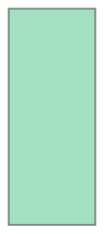

In [4]:
files[-4]

'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled\\31435.json'

In [8]:

f = open(files[-4], 'r')
jdata = json.load(f)
f.close() 
shapes = jdata["shapes"]

g = getGeoSeries(shapes)
len(g)

1

# Relationship

## utilities

In [29]:
def fill_relation(subject, predicate, object_):        
    relation = {}

    relation["subject"] = {}
    relation["subject"]["name"] = subject["label"]
    relation["subject"]["object_id"] = subject["object_id"]

    relation["predicate"] = predicate

    relation["object"] = {}
    relation["object"]["name"] = object_["label"]
    relation["object"]["object_id"] = object_["object_id"]
    
    return relation

def createPolygons(shapes):
    polygons = []
    for shape in shapes:
        shape_type = shape["shape_type"]
        points = shape["points"]
#         print("points:", points)
        if len(points) == 2:
            polygon = twoPoints_to_polygon(points[0], points[1])
        elif len(points) > 2:
            polygon = Polygon(points + [points[0]])
            
        polygons.append(polygon)
    return polygons

def getGeoSeries(shapes):
    polygons = createPolygons(shapes)
    return gpd.GeoSeries(polygons)

def getShape_all_id(shapes):
    
    try:
        all_ids = []
        for shape in shapes:
            
            all_ids.append(shape.get('object_id', None))
                          
    except Exception as e:
        print(e)
        return None
#     print(len(all_ids))
    return all_ids
                          
def renewShapeId(shapes):
    for idx, shape in enumerate(shapes):
        shape["object_id"] = idx + 1
        
def twoPoints_to_polygon(p1: (float, float), p2: (float, float))->Polygon:
#     print(p1, p2)
    p3 = (p1[0], p2[1])
    p4 = (p2[0], p1[1])
    return Polygon([p1, p3, p2, p4, p1])

# twoPoints_to_polygon((2076, 2214), (2163, 2431))

def isDuplicateID(id_list):
    id_set = set(id_list)
    if len(id_list) == len(id_set):
        return False
    else:
        return True
    
# isDuplicateID(["2", None, None])


def isHouse(label): # may have bug.
    house_name_list = ["duplex","bungalow", 'stilt-apartment',"house", "building", "single-house", "ranch", "twinhouse", "row-house", "building", "apartment", "condo", "mobile-home", "garage", "shed"]
    if ("house" in label.lower()) or (label.lower() in house_name_list):
        return True
    else:
        return False
    
def isDoor(label): # may have bug.
#     door_name_list = ["duplex","bungalow", "house", "building", "single-house", "ranch", "twinhouse", "row-house", "building", "apartment", "condo", "mobile-home", "garage", "shed"]
    if ("door" in label.lower()) and ( "garage" not in label.lower()):
        return True
    else:
        return False
    
def list_to_file(a_list, file_name):
    with open(file_name, mode='w', encoding='utf-8') as myfile:
        myfile.write('\n'.join(a_list))
        myfile.write('\n')

In [253]:
def get_mid_element(a_list):
    if not isinstance(a_list, list):
        return None
    
    cnt = len(a_list)
    if cnt == 0:
        return None
    
    m = cnt % 2
    
    mid_pos = int(cnt/2) + m - 1
    
    return a_list[mid_pos]
    
get_mid_element([1, 2, 4])   

2

In [401]:
def getOverlap(axis_range, number_list):
    overlap_range = []
    number_range = [min(number_list), max(number_list)]
    
    left_end = max(axis_range[0], number_range[0])
    right_end = min(axis_range[1], number_range[1])
    
    if right_end > left_end:
        return [left_end, right_end]
    else:
        return []

def isBetween(axis_range, num):
    if (num < axis_range[1]) and (num > axis_range[0]):
        return True
    else:
        return False

## House location relationship

In [374]:
def init_house_location_relation(shapes, geo_series):        
     
    relation_list = []
    
    # get house idx
    house_idxs = []
    for idx, shape in enumerate(shapes):
        if isHouse(shape['label']):
             house_idxs.append(idx)
    
    house_idxs = np.array(house_idxs)
                
    centroids = geo_series.centroid  
    
    house_centroids = centroids[house_idxs]
    
    sorted_house_x = np.argsort(centroids[house_idxs].x.tolist())
       
    sorted_house_ids = house_idxs[sorted_house_x]
         
    predicate = ''    
   
    for idx, house_id in enumerate(sorted_house_ids[:-1]):
        house_id_right = sorted_house_ids[idx + 1]
        predicate = "in_left_of"
        relation = fill_relation(shapes[house_id], predicate, shapes[house_id_right])
        relation_list.append(relation)  

            
    isPrint = True
    isPrint = False
    if isPrint: 
        if len(relation_list) > 0:
            [print(r['subject']["name"], r['subject']['object_id'], r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        else:
            print("No door is founded in porch:", shapes[idx]["object_id"])
            
        print("")
    
    print("Found %d location relationships between houses.\n" % len(relation_list))      
#     print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))
     
    return relation_list

##  House Components

In [521]:
def isHouseComponents(thing:str)->bool:
    house_components_list = ["deck", "garage", "door", "front-door", "window", "decorative-shutter", "dormer", "vent", "balcony", "basement", "chimney", 
                             "column", "cupola", "facade", "foundation", "gutter", "knewwwall", "overhang-floor", 
                            "patio", "porch", "porch-skirt", "roof", "sidelight", "toplight", "stair", "step", "storey",
                             "terrace", 
                             "vent-turet", "wall"]
    if thing in house_components_list:
        return True
    else:
        return False
    
def init_house_components(idx, shapes, geo_series):
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
    centroids = geo_series.centroid    
    
    centroids.within(geo_series[idx])
#     print("centroids:", centroids)
    insides_idx = centroids[centroids.within(geo_series[idx])].index
#             print(distances)

#     insides_idx = distances[distances < 1].index
#     print("type(insides):", type(list(insides_idx)))
#             print(insides_idx)
    for idx2 in insides_idx:
        thing = shapes[idx2]["label"]
        if isHouseComponents(thing):  
            predicate = "component_of"
            relation = fill_relation(shapes[idx2], predicate, shape)           
            relation_list.append(relation)
            
    isPrint = False
#     isPrint = True
    if isPrint:        
        print("Component of house: ", shape["object_id"])       
        [print(r['subject']["name"], r['subject']['object_id']) for r in relation_list]            
        print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    return relation_list    



## step relation

In [499]:
def init_step_relation(idx, shapes, geo_series):
    
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
# #     print(widths)
#     print(heights)
    
    near_ratio = 0.1 # assume that step can connect the object within near_ratio * height.
    
    step_height = heights[idx]
    near_idx = distances[distances < near_ratio * step_height].index
#     print("type(insides):", type((near_idx)))
#     print("near_idx:", near_idx)

    for idx2 in near_idx:
        thing = shapes[idx2]["label"]
        thing_object_id = shapes[idx2]["object_id"]
        object_ = shape["label"]
        object_object_id = shapes[idx]["object_id"]
        
        # connect objects
        connect_objects = ["porch", "deck", "door", "walkway", "landing"]
        
        if thing in connect_objects:             
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
    isPrint = True
#     isPrint = False

    if isPrint:        
        print(shape["label"],  object_object_id, " connect to:")       
        [print(r['object']["name"], r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list

## porch relation

In [540]:
def init_porch_relation(idx, shapes, geo_series):
    
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    
    centroids = geo_series.centroid    
    
    # if a door (centroids) inside a porch:
    centroids.within(geo_series[idx])
#     print("centroids:", centroids)
    insides_idx = centroids[centroids.within(geo_series[idx])].index
#     print("idx, shape.label", idx, shape["label"])
#     print("insides_idx:", idx, centroids.within(geo_series[idx]))
 
    predicate = ''
    for idx2 in insides_idx:
        thing = shapes[idx2]["label"]
        if "door" in thing.lower():  
            # connects to door            
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
    isPrint = True
#     isPrint = False
    if isPrint: 
        if len(relation_list) > 0:
            print(shapes[idx]["label"], shapes[idx]["object_id"])       
            [print(r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        else:
            print("No door is founded in porch:", shapes[idx]["object_id"])
            
#         print("")   
#     print(relation_list)
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))
     
    return relation_list

## sidewalk relationship

In [349]:
def init_sidewalk_relation(idx, shapes, geo_series):
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
# #     print(widths)
#     print(heights)
    
    near_ratio = 0.2 # assume that sidewalk can connect the object within near_ratio * height.
    
    sidewalk_height = heights[idx]
    near_idx = distances[distances < near_ratio * sidewalk_height].index
#     print("type(insides):", type((near_idx)))
#     print("near_idx:", near_idx)

    for idx2 in near_idx:
        thing = shapes[idx2]["label"]
        if thing == "road":
            predicate = "along_with"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation) 
  
        # connect objects
        connect_objects = ["door", "walkway", "driveway", "driveway-apron", "curb-cut", "pathway", "step", "stair"]        
        if thing in connect_objects:             
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
        # adjoin objects
        adjoin_objects = ["lawn", "parking-strip", "gravel", "flowerbed", "tree-pit"]        
        if thing in adjoin_objects:             
            predicate = "adjoin_to"
            relation = fill_relation(shapes[idx2], predicate, shape)
            relation_list.append(relation)   
            
        # can connect to road.
            
    isPrint = True
    isPrint = False

    if isPrint:        
        print(shapes[idx]["label"], "id:", shapes[idx]["object_id"])       
        [print(r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list    

## lawn in the front of house

In [549]:
def init_lawn_relation(idx, shapes, geo_series):
    
    print("Start init_lawn_relation():")
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)

    polygons = createPolygons(shapes)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
    centroids = geo_series.centroid
    
    lawn_points = polygons[idx].exterior.coords.xy
    lawn_points = np.array(lawn_points).transpose()
#     print("lawn_points:", lawn_points)
     
    lawn_front_points = []  # get the front points of lawn 
    lawn_front_points = lawn_points[lawn_points[:, 1] > centroids[idx].y]
#     print("centroids[idx].y:", centroids[idx].y)
#     print("lawn_front_points:\n", lawn_front_points)
    
  
    house_idxs = []
    for house_id, s in enumerate(shapes):
        if isHouse(s['label']):            
            house_idxs.append(house_id)
#     print(house_idxs)

                
    for house_idx in house_idxs:
#         print("house idx:", house_idx)
        shape_house = shapes[house_idx]
        house_points = polygons[house_idx].exterior.coords.xy
#         house_points = np.array(lawn_points).transpose()
        house_points_x = house_points[0]
    
        house_max_y =  max(house_points[1]) # most front point
#         print("house_max_y:", house_max_y)
        
#         print("house_points:\n", house_points)
        
        lawn_front_points = lawn_front_points[lawn_front_points[:, 1] > house_max_y]
        
        front_facade = [min(house_points_x), max(house_points_x)]   # x range of front facade
#         print("front_facade:", front_facade)

#         print("lawn_front_points:\n", lawn_front_points)
        
        if len(lawn_front_points) > 1:
            
#             print("lawn_front_points:\n", lawn_front_points)
#             print("shapes[house_idx][label]:", shapes[house_idx]["label"], shapes[house_idx]["object_id"])
#             print("front_facade:", front_facade)
            overlap = getOverlap(front_facade, lawn_front_points[:, 0])
#             print("overlap:", overlap)

            overlap_ratio = 0.2 # in x-axis, assume that the front line of lawn overlap with house more overlap_ratio * lawn_width.
            if len(overlap) == 2:
                overlap_len = overlap[1] - overlap[0]
                lawn_width = max(lawn_front_points[:, 0]) - min(lawn_front_points[:, 0])
                if overlap_len / lawn_width > overlap_ratio:
                    predicate = "in_front_of"
                    relation = fill_relation(shape, predicate, shape_house)
                    relation_list.append(relation)             
            
            
    isPrint = True
    isPrint = False

    if isPrint:        
        print(shapes[idx]["label"], shapes[idx]["object_id"])       
        [print(r["predicate"], ":", r['object']["name"],  r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list    

## Init relations

In [530]:
def initRelation(shapes):
    
    walkable_connection_list = []
    infront_of_list = []
    
    relations_list_all = []
    
    geo_series = getGeoSeries(shapes)

    house_location_relations = init_house_location_relation(shapes, geo_series)  
    relations_list_all += house_location_relations
    
    for idx, shape in enumerate(shapes):
        label = shape["label"]
        
        # house components
        if isHouse(label):
            house_relations = init_house_components(idx, shapes, geo_series)
            relations_list_all += house_relations
             
            
        # step connect to porch, walkway, door
        if "step" in label.lower():
            step_relations = init_step_relation(idx, shapes, geo_series)
            relations_list_all += step_relations

        # stair connect to porch, walkway, door. Treat it as "step"
        if "stair" in label.lower():
            step_relations = init_step_relation(idx, shapes, geo_series)
            relations_list_all += step_relations
            
        # porch connects to door
        if "porch" in label.lower():
            if not "-skirt" in label.lower():
                step_relations = init_porch_relation(idx, shapes, geo_series)
                relations_list_all += step_relations
                
        # sidewalk along with road and adjoin to other ojbects
        if "sidewalk" in label.lower():            
            sidewalk_relations = init_sidewalk_relation(idx, shapes, geo_series)
            relations_list_all += sidewalk_relations
            
        # lawn in the front of house
        if "lawn" in label.lower():            
            lawn_relations = init_lawn_relation(idx, shapes, geo_series)
            relations_list_all += lawn_relations            
     
    for idx, relation in enumerate(relations_list_all):
        relations_list_all[idx]["relationship_id"] = idx
        
    return relations_list_all
     
initRelation(shapes)

Found 0 location relationships between houses.

Found 0 relationships for single-house - 1



[]

In [ ]:
        # position of hourse components
        # porch in the middel/right/left part 
        # window in the middle/right/left part 
        # door in the middle/right/left part
        
        # drive way in the fron of garage 
        
        # porch-skirt is component of porch
            
        # house and others
        # lawn in the front of house
        
        # house is in the right/left of another house
        
        # sidewalk in the front of lawn
        
        # parking-strip along with road
        
        # flowerbed within lawn
        
        # trees within flowerbed
        
        
        # tree in the right part of parking-strip
        
        
        # at the right/left side of
        
          
        # road and its neighbors
        # strip near road
        
        # sidewalk along with road

In [167]:
!dir


 Volume in drive L is SSD
 Volume Serial Number is F8D5-37FF

 Directory of L:\Research\Jupyter_notebooks

10/07/2020  10:49 PM    <DIR>          .
10/07/2020  10:49 PM    <DIR>          ..
10/07/2020  09:41 AM    <DIR>          .idea
10/07/2020  04:44 PM    <DIR>          .ipynb_checkpoints
12/31/2019  10:59 PM         1,067,196 .~UNet_PyTorch_sidewalk_aerial-DVRPC2.ipynb
10/05/2020  08:49 PM         6,462,109 3.visualize_custom_SGDet.ipynb
07/05/2020  10:07 AM             3,915 acc.txt
02/23/2020  12:14 AM               101 address of the file location
12/25/2019  12:29 PM            53,247 ade20k_example.jpg
10/07/2020  09:41 AM    <DIR>          Auto-PyTorch
05/02/2020  12:12 PM               569 automl.7z
04/26/2020  10:27 PM               862 automl.py
05/02/2020  07:20 PM             6,623 Auto_pytorch_test.ipynb
02/04/2020  11:43 PM             3,663 basic_example_writer_sgskip.ipynb
07/05/2020  10:02 AM                27 best_acc.txt
04/17/2020  05:31 PM           249,406 biki

In [206]:
g.distance(g[0])  

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.000000
8        0.000000
9        0.000000
10      73.636364
11     950.216450
12     628.138528
13     985.204991
14     560.499109
15     193.398268
16     850.359527
17     949.350649
18    1131.890332
19     739.033189
20     528.715729
21     919.985570
22     594.588745
23     704.112554
24    1024.747475
25    1170.653907
26    1198.724083
27    1083.080808
28     214.632035
29      34.632035
30     346.494949
31     152.272727
32     223.272727
33       0.000000
34       0.000000
35     840.944382
36     523.953824
37    1107.173779
38      27.272727
dtype: float64

# Process the json

## convert the attributes in the names

In [72]:
all_labels = []

for jfile in files[:]:
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
#     
#     print(jdata["shapes"])
#     print(jdata["shapes"][0].keys())
    shapes = jdata["shapes"]
    
    all_ids = getShape_all_id(shapes)
#     print("all_ids:", all_ids)
    
    Whether_duplicateID = isDuplicateID(all_ids)
#     print("isDuplicateID:", Whether_duplicateID)
    if Whether_duplicateID:
        renewShapeId(shapes)
    
    gpd_series = getGeoSeries(shapes)
    
    
#     print(len(all_ids))

    kelt_objects = ["house", 'door', 'step']
    new_shapes = []
    
    
    for idx, shape in enumerate(shapes[:]):
         
        
        # read attributes
        attributes = shape.get("attributes", {})
        
        # add object_id
        object_id = shape.get("object_id", None)
        if not object_id:
            object_id = idx + 1
            
        shapes[idx]["object_id"] = object_id
#         print("object_id:", shapes[idx]["object_id"])
        
        
        label = shape["label"]
#         print("raw label:", label)
        shape["raw_label"] = label
        fields = label.split("_")
        
        
        
        # process label: remove attributes
        shape["label"] = fields[0]
        
        if isHouse(shape["label"]):
            shape["label"] = "house"
            
        if isDoor(shape["label"]):
            shape["label"] = "door"
            
        if shape['label'] not in kelt_objects:
#             shapes.remove(shape)
            continue
        
        all_labels.append(shape["label"])
        
#         print("raw fields:", fields)
#         print("raw len of fields:", len(fields))
        
        
        
        if len(fields)>1:            
            fields = fields[1:]
        
        else:
            fields = []
            
        # process storey_cnt for house
        if ("house" in label) and (len(fields) > 0):
            if fields[0].isnumeric():
                attributes["storey_cnt"] = fields[0]
#                 print("Added attributes.storey_cnt: ", attributes["storey_cnt"])
                
                
        # process step_cnt for step
        if ("step" in label) and (len(fields) > 0):
            if fields[0].isnumeric():
                attributes["step_cnt"] = fields[0]
#                 print("Added attributes.step_cnt: ", attributes["step_cnt"])
                                
                
                
        shape['attributes'] = attributes
         
            
        print("new label:", shape["label"])
        
        new_shapes.append(shape)
        
#         print("attributes:", attributes)
#         print("attributes filed values:", fields)
#         print("")
        
#     with open('data.txt', 'w') as outfile:
    
    basename = os.path.basename(jfile)
    new_name = os.path.join(saved_path, basename)
    
    jdata['shapes'] = new_shapes

    f2 = open(new_name, 'w')
    json.dump(jdata, f2, indent=2)
    f2.close()
 
            

L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2183.json
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2276.json
new label: house
new label: house
new label: house
new label: door
new label: step
new label: door
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2277.json
new label: house
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2279.json
new label: house
new label: house
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2280.json
new label: house
new label: step
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2282.json
new label: house
new label: door
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2283.json
new label: house
new label: door
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2287.json
new label: house
new label: house


new label: house
new label: step
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31082.json
new label: house
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31085.json
new label: house
new label: door
new label: door
new label: door
new label: door
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31086.json
new label: house
new label: house
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31087.json
new label: house
new label: house
new label: door
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31088.json
new label: house
new label: house
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31090.json
new label: house
new label: door
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31091.json
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_proce

new label: step
new label: step
new label: step
new label: house
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31189.json
new label: house
new label: step
new label: door
new label: house
new label: step
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31191.json
new label: house
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31194.json
new label: house
new label: house
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31195.json
new label: house
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31196.json
new label: house
new label: step
new label: door
new label: house
new label: house
new label: step
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31197.json
new label: house
new label: door
new label: house
new label: door
new label: house
new label: door
new label: step
L:\Datasets\ocean

L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31264.json
new label: house
new label: house
new label: door
new label: door
new label: door
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31265.json
new label: house
new label: door
new label: step
new label: house
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31266.json
new label: house
new label: door
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31267.json
new label: house
new label: door
new label: step
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31268.json
new label: house
new label: door
new label: door
new label: house
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31271.json
new label: house
new label: step
new l

new label: house
new label: house
new label: house
new label: house
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: step
new label: door
new label: step
new label: step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31369.json
new label: house
new label: house
new label: house
new label: house
new label: house
new label: house
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31378.json
new label: house
new label: house
new label: door
new label: door
new label: door
new label: door
new label: door
new label: door
new label: step
new label: step
new label: step
new label: house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31380.json
new label: step
new label: door
new label: step
new label: house
new label: door
new label: step
L:\Datasets\ocean_city

In [73]:
all_labels

['house',
 'house',
 'house',
 'house',
 'door',
 'step',
 'door',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'step',
 'door',
 'house',
 'door',
 'house',
 'house',
 'door',
 'step',
 'house',
 'house',
 'house',
 'house',
 'step',
 'step',
 'door',
 'house',
 'step',
 'house',
 'door',
 'house',
 'house',
 'step',
 'door',
 'house',
 'door',
 'house',
 'house',
 'house',
 'step',
 'door',
 'door',
 'step',
 'door',
 'house',
 'door',
 'step',
 'house',
 'house',
 'door',
 'house',
 'step',
 'house',
 'door',
 'house',
 'step',
 'house',
 'step',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'step',
 'step',
 'door',
 'door',
 'door',
 'door',
 'step',
 'step',
 'house',
 'house',
 'house',
 'step',
 'door',
 'door',
 'door',
 'step',
 'door',
 'house',
 'house',
 'house',
 'house',
 'door',
 'house',
 'door',
 'door',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'house',
 'step',
 'house',
 'house',
 'hous

In [74]:
len(all_labels)

1202

In [76]:
all_labels_set = list(set(all_labels))
all_labels_set

['step', 'house', 'door']

['step', 'house', 'door']

## get object names in jsons

In [77]:
# image_dir = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled'
saved_path = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json'

extension =  'json'
files = glob.glob(os.path.join(saved_path, "*." + extension))
files = natsorted(files)
files

['L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2183.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2276.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2277.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2279.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2280.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2282.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2283.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2287.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2288.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2290.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2291.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2293.json',
 'L:

In [80]:
all_labels = []

for jfile in files[:]:
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
 
    shapes = jdata["shapes"]
  
    for idx, shape in enumerate(shapes[:]): 
        all_labels.append(shape["label"])
        print(shape["label"])

L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2183.json
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2276.json
house
house
house
door
step
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2277.json
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2279.json
house
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2280.json
house
step
door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2282.json
house
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2283.json
house
door
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2287.json
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2288.json
house
house
step
step
door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2290.json
house
step
house
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed

door
house
house
step
door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31197.json
house
door
house
door
house
door
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31198.json
house
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31199.json
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31200.json
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31201.json
house
step
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31202.json
house
step
door
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31203.json
house
step
house
step
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31204.json
house
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31205.json
house
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31206.json
house
house
step
door
house
L:\Datasets\ocean_city\pa

house
door
step
house
door
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31316.json
house
house
house
door
door
door
door
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31323.json
house
house
house
door
door
door
door
house
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31324.json
door
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31325.json
house
step
door
door
house
step
house
step
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31326.json
house
door
step
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31327.json
house
door
door
door
door
house
house
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31328.json
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31330.json
house
step
door
house
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31331.json
house
house
step
do

In [81]:
all_labels_set = list(set(all_labels))
all_labels_set

['step', 'house', 'door']

## convert cleaned json to YOLO-v3 train.txt

In [ ]:
import numpy as np

In [93]:
train_lines = []

for jfile in files[:]:
    train_fields = []
    train_fields.append(jfile)
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
 
    shapes = jdata["shapes"]
    
    label_list = ["door", "house", "step"]
  
    for idx, shape in enumerate(shapes[:]): 
        
        label = shape["label"]
        points = shape["points"]
        points = np.array(points).astype(int)

        
        try:
            label_idx = label_list.index(label)
            min_x = min(points[:, 0])
            max_x = min(points[:, 0])
            min_y = min(points[:, 1])
            max_y = min(points[:, 1])
                        
            train_fields.append(str(min_x)) 
            train_fields.append(str(min_y)) 
            train_fields.append(str(max_x)) 
            train_fields.append(str(max_y)) 
            train_fields.append(str(label_idx)) 
        
        except Exception as e:
            print("Error: ", e)
            continue
            
    if len(train_fields) > 5:    
        train_lines.append(",".join(train_fields))
        
train_lines         
        
#         all_labels.append()
#         print(shape["label"])

L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2183.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2276.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2277.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2279.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2280.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2282.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2283.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2287.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2288.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2290.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2291.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2293.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\2294.json
L:\Datasets\ocean_city\pa

L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31341.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31342.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31344.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31345.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31346.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31347.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31348.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31349.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31350.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31353.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31354.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31356.json
L:\Datasets\ocean_city\pano_twoside_clips_sampled_processed_json\31358.json
L:\Datasets\

['L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2183.json,416,382,416,382,1',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2276.json,1102,947,1102,947,1,21,1189,21,1189,1,2070,1177,2070,1177,1,1421,1790,1421,1790,0,2508,2153,2508,2153,2,2488,1922,2488,1922,0,3282,1127,3282,1127,1',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2277.json,0,582,0,582,1,3302,578,3302,578,1',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2279.json,0,1237,0,1237,1,1390,1288,1390,1288,1,2877,1262,2877,1262,1',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2280.json,2085,1399,2085,1399,1,2410,1789,2410,1789,2,2456,1599,2456,1599,0',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2282.json,1155,1320,1155,1320,1,1563,1689,1563,1689,0,2461,1088,2461,1088,1',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\2283.json,351,1246,351,1246,1,888,1674,

In [86]:
train_fields

['L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\31685.json',
 'L:\\Datasets\\ocean_city\\pano_twoside_clips_sampled_processed_json\\31685.json',
 2279.5454545454545,
 1386.3636363636363,
 2279.5454545454545,
 1386.3636363636363,
 0]

In [98]:
file_name = r'L:\Datasets\ocean_city\pano_twoside_clips_sampled\train.txt'
list_to_file(train_lines, file_name)


## convert to YOLO v5 train txt files from each image

In [1]:
json_path = r'/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json'
saved_path =  r'/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json/yolo_v5/'

extension =  'json'
files = glob.glob(os.path.join(json_path, "*." + extension))
files = natsorted(files)
files

NameError: name 'glob' is not defined

In [47]:
train_lines = []

for jfile in files[:]:
    object_lines = []
    
#     train_fields.append(jfile)
#     print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
    
    basename = os.path.basename(jfile)
 
    shapes = jdata["shapes"]
    
    label_list = ["door", "house", "step"]
    
    img_w = jdata["imageWidth"]
    img_h = jdata["imageHeight"]
  
    for idx, shape in enumerate(shapes[:]): 
        
        label = shape["label"]
        points = shape["points"]
        points = np.array(points) 

        object_line = []
        
        train_fields = []
        
        try:
            label_idx = label_list.index(label)
            min_x = min(points[:, 0])
            max_x = max(points[:, 0])
            min_y = min(points[:, 1])
            max_y = max(points[:, 1])
            
            print(max_x, max_y, min_x, min_y)
            
            center_x = (min_x + max_x)/2
            center_x = center_x / img_w
            
            center_y = (min_y + max_y)/2
            center_y = center_y / img_h
            
            h = (max_y - min_y)/img_h            
            w = (max_x - min_x)/img_w
            
            
#             train_fields.append(str(label_idx))             
#             train_fields.append("{}"(center_x)) 
#             train_fields.append(str(center_y)) 
#             train_fields.append(str(w)) 
#             train_fields.append(str(h)) 
            
            object_line = f"{label_idx} {center_x:.6f} {center_y:.6f} {w:.6f} {h:.6f}"
              
            
#             object_line.append(",".join(train_fields) + '\n')
            
            print(object_line)                   

            object_lines.append(object_line)
             
        
        except Exception as e:
            print("Error: ", e)
            continue

             
    print(len(object_line))
    new_name = os.path.join(saved_path, basename.replace(".json", '.txt'))
    list_to_file(object_lines, new_name)
        
 

1824.695652173913 2509.0434782608695 416.0 382.95652173913044
1 0.273522 0.353027 0.343920 0.519064
37
1816.6666666666667 2386.1111111111113 1102.7777777777778 947.2222222222223
1 0.356377 0.406901 0.174289 0.351291
471.4285714285714 2350.0 21.428571428571427 1189.2857142857142
1 0.060163 0.432042 0.109863 0.283378
3112.5 2377.5 2070.0 1177.5
1 0.632629 0.433960 0.254517 0.292969
1513.8461538461538 2052.3076923076924 1421.5384615384614 1790.0
0 0.358323 0.469032 0.022536 0.064040
2778.846153846154 2384.6153846153848 2508.653846153846 2153.846153846154
2 0.645447 0.554011 0.065965 0.056340
2580.7692307692305 2163.4615384615386 2488.4615384615386 1922.1153846153845
0 0.618803 0.498728 0.022536 0.058922
4086.2068965517246 2303.4482758620693 3282.7586206896553 1127.5862068965519
1 0.899532 0.418827 0.196154 0.287076
37
3294.260869565217 2543.8260869565215 0.0 582.0
1 0.402131 0.381571 0.804263 0.478961
4089.913043478261 2448.173913043478 3302.9565217391305 578.6086956521739
1 0.902450 0.36

2040.5384615384614 2465.3846153846152 859.7692307692307 738.4615384615385
1 0.354041 0.391095 0.288274 0.421612
2011.3636363636363 2472.7272727272725 1790.909090909091 2277.2727272727275
2 0.464145 0.579834 0.053822 0.047718
3477.7777777777774 2525.9259259259256 2377.777777777778 940.7407407407406
1 0.714789 0.423177 0.268555 0.387008
723.1818181818182 2362.090909090909 0.0 495.0
1 0.088279 0.348766 0.176558 0.455833
37
3205.2857142857138 2114.7142857142853 1716.0 432.57142857142856
1 0.739376 0.382705 0.447502 0.505452
2205.128205128205 1597.4358974358975 1915.3846153846152 1258.974358974359
0 0.619067 0.429148 0.087062 0.101701
2958.974358974359 1582.051282051282 2694.871794871795 1271.7948717948718
0 0.849436 0.428763 0.079358 0.093226
37
3037.5 2409.375 1662.5 912.5
1 0.573730 0.405502 0.335693 0.365448
2585.0 2488.3333333333335 2196.666666666667 2318.3333333333335
2 0.583700 0.586751 0.094808 0.041504
2370.0 2283.3333333333335 2245.0 1951.6666666666667
0 0.563354 0.516968 0.030518

588.8888888888888 2414.814814814815 14.814814814814813 814.8148148148148
1 0.073694 0.394242 0.140155 0.390625
37
2495.3488372093025 2074.4186046511627 1411.6279069767443 937.2093023255815
1 0.586986 0.452468 0.325637 0.341710
2180.0 2060.0 2069.230769230769 1776.923076923077
0 0.638406 0.576461 0.033284 0.085059
1895.3846153846152 2061.5384615384614 1787.6923076923076 1772.3076923076922
0 0.553347 0.575999 0.032359 0.086908
3325.7142857142853 2017.1428571428569 2779.9999999999995 1065.7142857142856
1 0.917325 0.463170 0.163977 0.285886
37
2767.9245283018868 1830.1886792452829 1603.7735849056603 1171.698113207547
1 0.656806 0.451005 0.349805 0.197864
2378.813559322034 1713.5593220338983 2299.1525423728813 1522.033898305085
0 0.702819 0.486117 0.023937 0.057550
2472.0338983050847 1885.5932203389832 2333.898305084746 1731.35593220339
2 0.722045 0.543412 0.041507 0.046345
37
1915.2542372881358 1957.6271186440679 881.3559322033899 1022.0338983050848
1 0.420164 0.447665 0.310667 0.281128
13

0 0.485692 0.522806 0.024414 0.040937
2031.730769230769 1983.6538461538462 1844.230769230769 1823.076923076923
0 0.473140 0.464689 0.045776 0.039203
3812.3076923076924 2238.4615384615386 3666.153846153846 2041.5384615384614
0 0.912898 0.522461 0.035682 0.048077
37
1944.5714285714284 2007.5714285714284 1123.142857142857 1064.7142857142856
1 0.460895 0.461581 0.246823 0.283310
2748.142857142857 1989.7142857142856 2180.285714285714 1039.7142857142856
1 0.740449 0.455143 0.170630 0.285457
2565.979381443299 1985.5670103092784 2258.762886597938 1824.7422680412371
2 0.724871 0.572462 0.092313 0.048325
2324.7422680412374 1790.721649484536 2251.546391752577 1639.1752577319587
0 0.687543 0.515309 0.021994 0.045537
37
2362.5 2070.8333333333335 1627.0833333333335 1291.6666666666667
1 0.599397 0.505183 0.220979 0.234125
1957.5 2057.5 1681.25 1906.25
2 0.546687 0.595515 0.083008 0.045448
1916.1016949152543 1871.1864406779662 1827.9661016949153 1656.7796610169491
0 0.562510 0.530043 0.026483 0.064425

1706.8493150684933 2163.0136986301372 1561.6438356164383 1839.7260273972604
0 0.398986 0.488616 0.035451 0.078928
2482.1917808219177 1694.5205479452054 2208.219178082192 1384.9315068493152
0 0.572560 0.375910 0.066888 0.075583
1730.13698630137 1683.5616438356165 1449.3150684931506 1391.7808219178082
0 0.388117 0.375408 0.068560 0.071236
4091.428571428571 2394.285714285714 3259.9999999999995 1065.7142857142856
1 0.897391 0.422363 0.202985 0.324358
3988.571428571428 2565.7142857142853 3545.7142857142853 2208.5714285714284
2 0.919713 0.582799 0.108119 0.087193
3747.4576271186443 2164.406779661017 3598.305084745763 1820.3389830508474
0 0.896700 0.486419 0.036414 0.084001
3779.661016949153 1664.406779661017 3486.4406779661017 1357.6271186440679
0 0.886975 0.368901 0.071587 0.074897
705.7142857142857 2422.8571428571427 5.7142857142857135 1128.5714285714284
1 0.086844 0.433524 0.170898 0.315988
448.57142857142856 1697.1428571428569 157.14285714285714 1377.142857142857
0 0.073940 0.375279 0.07

1339.9999999999998 2208.695652173913 1241.5584415584415 1979.2207792207791
0 0.315132 0.511220 0.024034 0.056024
2506.666666666667 2046.6666666666667 2356.666666666667 1685.0
0 0.593669 0.455526 0.036621 0.088298
37
753.6296296296296 2329.6296296296296 0.0 1384.0
1 0.091996 0.453324 0.183992 0.230867
1979.5555555555552 2370.3703703703704 920.2962962962963 1133.3333333333333
1 0.353986 0.427698 0.258608 0.302011
3442.5185185185182 2359.259259259259 2335.111111111111 1240.7407407407406
1 0.705277 0.439453 0.270363 0.273076
4095.0 2306.25 3525.0 1095.0
1 0.930176 0.415192 0.139160 0.295715
3802.2727272727275 2088.6363636363635 3590.909090909091 1838.6363636363637
0 0.902488 0.479403 0.051602 0.061035
3799.9999999999995 1724.074074074074 3598.148148148148 1468.5185185185185
0 0.903094 0.389721 0.049280 0.062391
2714.7727272727275 2137.5 2506.25 1871.875
0 0.637332 0.489426 0.050909 0.064850
2710.2272727272725 1760.2272727272727 2455.681818181818 1490.909090909091
0 0.630604 0.396867 0.0621

## rowcol_to_spherial

In [21]:
from math import *

def castesian_to_shperical(col, row, fov_h, height, width):  # yaw: set the heading, pitch
    """
    Convert the row, col to the  spherical coordinates 
    :param row, cols: 
    :param fov_h:
    :param height:
    :param width:
    :return:
    """
     
    col = col - width/2  # move the origin to center
    row = height/2 -row
 
    fov_v = atan((height * tan((fov_h / 2)) / width)) * 2
     
    
    r = (width/2)/tan(fov_h/2)
     
    s = sqrt(col**2 + r**2)
    
    theta = atan(row/s)
    phi = atan(col/r)
    
    print("fov_v, r, s:", fov_v, r, s)
     
    return phi, theta



In [23]:
import math

col = 1491
  
row = 2101
# row = 1856
fov_h = math.pi/2
height = 4096
width = 4096
castesian_to_shperical(col, row, fov_h, height, width)

fov_v, r, s: 1.5707963267948966 2048.0000000000005 2122.393224640524


(-0.26554954089837773, -0.024966621041549453)

In [12]:
# -*- coding: utf-8 -*-

'''
LabelMe JSON format -> YOLO txt format
save dataset (학습 자료) in dataset/ 
output will be saved in result/
JSON format will be moved to json_backup/
Finally, please manually copy text file together with image into 1 folder. (Easier to maintain)
마지막으로 txt파일이랑 이미지파일이랑 같은 폴더에 복사하세요 (관리하기 위한 쉬움)
'''

import os
from os import walk, getcwd
from PIL import Image

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)
    
    
"""-------------------------------------------------------------------""" 

""" Configure Paths"""   
mypath =  r'/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json/'

outpath =  r'/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json/yolo_v5/'

json_backup =r"/media/huan/SSD/Datasets/ocean_city/pano_twoside_clips_sampled_processed_json/yolo_v5/json_backup/"

wd = getcwd()
#list_file = open('%s_list.txt'%(wd), 'w')

""" Get input json file list """
json_name_list = []
for file in os.listdir(mypath):
    if file.endswith(".json"):
        json_name_list.append(file)
    

""" Process """
for json_name in json_name_list:
    txt_name = json_name.rstrip(".json") + ".txt"
    """ Open input text files """
    txt_path = mypath + json_name
    print("Input:" + txt_path)
    txt_file = open(txt_path, "r")
    
    """ Open output text files """
    txt_outpath = outpath + txt_name
    print("Output:" + txt_outpath)
    txt_outfile = open(txt_outpath, "a")

    """ Convert the data to YOLO format """ 
    lines = txt_file.read().split('\r\n')   #for ubuntu, use "\r\n" instead of "\n"
    for idx, line in enumerate(lines):
        if ("lineColor" in line):
            break     #skip reading after find lineColor
    if ("label" in line):
            x1 = float(lines[idx+5].rstrip(','))
            y1 = float(lines[idx+6])
            x2 = float(lines[idx+9].rstrip(','))
            y2 = float(lines[idx+10])
            cls = line[16:17]

        #in case when labelling, points are not in the right order
            xmin = min(x1,x2)
            xmax = max(x1,x2)
            ymin = min(y1,y2)
            ymax = max(y1,y2)
#             img_path = str('%s/dataset/%s.jpg'%(wd, os.path.splitext(json_name)[0]))

            im=Image.open(img_path)
            w= int(im.size[0])
            h= int(im.size[1])

            print(w, h)
            print(xmin, xmax, ymin, ymax)
            b = (xmin, xmax, ymin, ymax)
            bb = convert((w,h), b)
            print(bb)
            txt_outfile.write(cls + " " + " ".join([str(a) for a in bb]) + '\n')

    os.rename(txt_path,json_backup+json_name)	#move json file to backup folder

IndentationError: unexpected indent (<ipython-input-12-0f9907b4a808>, line 77)

NameError: name 'files' is not defined

## initialize the relationships

In [545]:
image_dir = r'L:\Datasets\ocean_city\processed_json'
extension =  'json'
files = glob.glob(os.path.join(image_dir, "*." + extension))
files = natsorted(files)
[print(i, file) for i, file in enumerate(files)]

0 L:\Datasets\ocean_city\processed_json\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json
1 L:\Datasets\ocean_city\processed_json\2_N2TakAa4EvhSCDIb44lEBw_83.71.json
2 L:\Datasets\ocean_city\processed_json\3_n4aTTgHhJ2AkPbSg0X3MfA_11.99.json
3 L:\Datasets\ocean_city\processed_json\4_7pBBmj5k9GAh1o-n4ctSpQ_56.94.json
4 L:\Datasets\ocean_city\processed_json\5_0_Z25VniDxurxsixrPV1LA_33.93.json
5 L:\Datasets\ocean_city\processed_json\6_WHxaTCBPZ8v_L8S9Nr24fA_43.17.json
6 L:\Datasets\ocean_city\processed_json\8_M3I2qNQeBB2MFg3IHuCbig_104.0.json
7 L:\Datasets\ocean_city\processed_json\9_as2lf1LPPhGI1D5DEQtDyA_55.07.json
8 L:\Datasets\ocean_city\processed_json\10_piJ3-HBctCPJ9qejZZesEQ_121.73.json
9 L:\Datasets\ocean_city\processed_json\11_eD6yAl7EAam1xa8Z6_5Amw_31.49.json
10 L:\Datasets\ocean_city\processed_json\13_xixwgkh4GQ9uyj7DHwqcgw_54.73.json
11 L:\Datasets\ocean_city\processed_json\14_mvxG0Y8r3Yzv-4e1_6esjQ_115.1.json
12 L:\Datasets\ocean_city\processed_json\15_IU40Fjvi2newL6AnPrtlvQ_128.5.json
13

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [550]:

sampled_files = files[:]
for jfile in sampled_files:
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
#     
#     print(jdata["shapes"])
#     print(jdata["shapes"][0].keys())
    shapes = jdata["shapes"]
    
    relations = initRelation(shapes)
    
      
                
    jdata["relationships"] = relations
         
             
        
#     with open('data.txt', 'w') as outfile:
    f2 = open(jfile, 'w')
    json.dump(jdata, f2, indent=2)
    f2.close()
#     json.dump()
            
    

L:\Datasets\ocean_city\processed_json\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json
Found 1 location relationships between houses.

step 2  connect to:
porch 26


Found 1 relationships for step - 2

stair 3  connect to:


Found 0 relationships for stair - 3

stair 4  connect to:


Found 0 relationships for stair - 4

stair 5  connect to:


Found 0 relationships for stair - 5

Found 18 relationships for single-house - 6

Found 3 relationships for single-house - 8

porch 26
connect_to : front-door 1
Found 1 relationships for porch - 26

L:\Datasets\ocean_city\processed_json\2_N2TakAa4EvhSCDIb44lEBw_83.71.json
Found 5 location relationships between houses.

Found 1 relationships for single-house - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 1 relationships for townhouse - 3

Found 3 relationships for townhouse - 4

Found 1 relationships for garage - 5

Found 1 relationships for garage - 6

Found 1 relationships for garage - 7

L:\Datasets\ocean_city\processed_json\3_n4aTTgHh

Found 0 location relationships between houses.

Found 0 relationships for house - 1

L:\Datasets\ocean_city\processed_json\37_t8_9FpsLDTV3rCR8x5DX-w_72.3.json
Found 5 location relationships between houses.

Found 3 relationships for single-house - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 4 relationships for single-house - 4

step 5  connect to:


Found 0 relationships for step - 5

Found 1 relationships for garage - 7

Found 1 relationships for garage - 8

Found 1 relationships for garage - 9

Found 2 relationships for single-house - 10

step 11  connect to:
door 12


Found 1 relationships for step - 11

L:\Datasets\ocean_city\processed_json\38_qyA_621V5O11QOJ1wj9rDQ_344.19.json
Found 2 location relationships between houses.

Found 0 relationships for house-group - 1

Found 0 relationships for house-group - 2

Found 0 relationships for house-group - 3

L:\Datasets\ocean_city\processed_json\39_k-rY6EGYm4EicR2OzqYq7A_42.77.json
Found 3 location relationships bet

Found 0 relationships for single-house - 1

Found 0 relationships for single-house - 2

Found 0 relationships for single-house - 3

L:\Datasets\ocean_city\processed_json\73_daaRpJftM26Cdkve2_ETiQ_313.67.json
Found 4 location relationships between houses.

Found 4 relationships for single-house - 1

Found 0 relationships for single-house - 2

Found 0 relationships for single-house - 3

Found 1 relationships for garage - 4

Found 1 relationships for garage - 5

step 7  connect to:


Found 0 relationships for step - 7

L:\Datasets\ocean_city\processed_json\74_o6RTAL5PYdeTYo0JnqKGCQ_312.82.json
Found 2 location relationships between houses.

Found 3 relationships for single-house - 1

Found 1 relationships for garage - 2

Found 0 relationships for single-house - 4

L:\Datasets\ocean_city\processed_json\75_YqtSLYpq8bkzFukNG-nntw_232.84.json
Found 2 location relationships between houses.

Found 4 relationships for bungalow - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 

Found 1 relationships for garage - 6

stair 7  connect to:
deck 8


Found 1 relationships for stair - 7

L:\Datasets\ocean_city\processed_json\95_rONwgumLQUY07pB5R6yUOA_233.5.json
Found 4 location relationships between houses.

Found 8 relationships for bungalow - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 4 relationships for single-house - 11

Found 1 relationships for garage - 12

Found 1 relationships for garage - 13

stair 16  connect to:
deck 14


Found 1 relationships for stair - 16

Found 1 relationships for single-house - 17

L:\Datasets\ocean_city\processed_json\96_1XFkv_-3Vqc91Bvz91uUvA_302.9.json
Found 1 location relationships between houses.

Found 7 relationships for bungalow - 1

step 2  connect to:
door 4
porch 6


Found 2 relationships for step - 2

porch 6
connect_to : door 4
Found 1 relationships for porch - 6

Found 0 relationships for house-group - 9

L:\Datasets\ocean_city\processed_json\97_iKNouL65svY3oqxVHRyY7Q_334.54.json
Found 2 location

L:\Datasets\ocean_city\processed_json\120_E3ALAGR9jCEVDheUGlOk_Q_217.83.json
Found 4 location relationships between houses.

Found 9 relationships for single-house - 1

step 4  connect to:


Found 0 relationships for step - 4

Found 1 relationships for garage - 7

Found 6 relationships for single-house - 10

Found 1 relationships for garage - 11

Found 0 relationships for single-house - 16


Found 1 relationships for sidewalk - 18

L:\Datasets\ocean_city\processed_json\121_VRMFwnO34XgP7HLbVk24uA_141.04.json
Found 0 location relationships between houses.

Found 0 relationships for house-group - 1

L:\Datasets\ocean_city\processed_json\122_QhVu6UqlvkQJWCsvI3xANw_311.43.json
Found 2 location relationships between houses.

Found 11 relationships for single-house - 1

step 2  connect to:
porch 5
walkway 21


Found 2 relationships for step - 2

porch 5
connect_to : door 4
Found 1 relationships for porch - 5

Found 2 relationships for single-house - 13


Found 3 relationships for sidewalk - 1

Found 11 relationships for single-house - 1

Found 1 relationships for garage - 2


Found 2 relationships for sidewalk - 17


Found 2 relationships for sidewalk - 18

Start init_lawn_relation():

Found 1 relationships for lawn - 19

Start init_lawn_relation():

Found 0 relationships for lawn - 20

L:\Datasets\ocean_city\processed_json\143_IfrVajcmC48ybxrfNz31nQ_217.78.json
Found 3 location relationships between houses.

Found 4 relationships for single-house - 1

step 3  connect to:


Found 0 relationships for step - 3

Found 0 relationships for single-house - 12

Found 0 relationships for single-house - 13

Found 0 relationships for house-group - 14

Start init_lawn_relation():

Found 3 relationships for lawn - 17

Start init_lawn_relation():

Found 1 relationships for lawn - 18

L:\Datasets\ocean_city\processed_json\144_NRcaan0pOUnb4nJCAA5B4A_219.86.json
Found 3 location relationships between houses.

Found 6 relationships for bungalow - 1


Found 2 relationships for sidewalk - 10

S

Found 3 relationships for sidewalk - 7


Found 4 relationships for sidewalk - 8

Found 0 relationships for building - 10

L:\Datasets\ocean_city\processed_json\164_2BU5g_Mt1a7L6031ssQJzQ_145.15.json
Found 2 location relationships between houses.

Found 7 relationships for bungalow - 1

step 7  connect to:
porch 8
walkway 15


Found 2 relationships for step - 7

porch 8
connect_to : door 5
Found 1 relationships for porch - 8

Start init_lawn_relation():

Found 2 relationships for lawn - 16

Start init_lawn_relation():

Found 2 relationships for lawn - 17


Found 4 relationships for sidewalk - 18


Found 2 relationships for sidewalk - 19

Found 1 relationships for house - 20

Found 0 relationships for house-group - 21

L:\Datasets\ocean_city\processed_json\165_uMgYUtFt1-s-Y04jeoHJ7A_142.33.json
Found 2 location relationships between houses.

Found 17 relationships for single-house - 1

step 2  connect to:
landing 4
porch 6
door 8


Found 3 relationships for step - 2

step 3  connect to:


porch 6
connect_to : front-door 8
Found 1 relationships for porch - 6


Found 4 relationships for sidewalk - 15

Start init_lawn_relation():

Found 1 relationships for lawn - 16

porch 19
connect_to : sliding-door 22
Found 1 relationships for porch - 19

Found 3 relationships for single-house - 25

Found 13 relationships for single-house - 26

step 27  connect to:
porch 39


Found 1 relationships for step - 27

stair 32  connect to:
door 33


Found 1 relationships for stair - 32

porch 39
connect_to : front-door 28
Found 1 relationships for porch - 39

L:\Datasets\ocean_city\processed_json\192_SEkj2oHWNtV5D7CMddAKlA_131.13.json
Found 2 location relationships between houses.

Found 27 relationships for single-house - 1

step 3  connect to:
door 19
walkway 61


Found 2 relationships for step - 3

porch 4
connect_to : front-door 5
Found 1 relationships for porch - 4

step 11  connect to:
porch 4


Found 1 relationships for step - 11

step 12  connect to:
porch 4


Found 1 relationships fo